# Stacking Algorithms
### Combination of two or more estimators to find the best way to combine different machine learning algorithms having different perks on specific problem

>The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

**Stacking addresses the question:**

* Given multiple machine learning models that are skillful on a problem, but in different ways, how do you choose which model to use (trust)?

**The approach to this question is to use another machine learning model that learns when to use or trust each model in the ensemble.**

* Unlike bagging, in stacking, `the models are typically different` (e.g. not all decision trees) and fit on the same dataset (e.g. instead of samples of the training dataset).
* Unlike boosting, in stacking, `a single model is used to learn how to best combine the predictions from the contributing models` (e.g. instead of a sequence of models that correct the predictions of prior models).

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model.

* Level-0 Models (`Base-Models`): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (`Meta-Model`): Model that learns how to best combine the predictions of the base models.

The meta-model is trained on the predictions made by base models on out-of-sample data. That is, data not used to train the base models is fed to the base models, predictions are made, and these predictions, along with the expected outputs, provide the input and output pairs of the training dataset used to fit the meta-model.

The most common approach to preparing the training dataset for the meta-model is via `k-fold cross-validation` of the base models, where the `out-of-fold` predictions are used as the basis for the training dataset for the meta-model.

**Base-models are often complex and diverse.**
> Base-Models: Use a diverse range of models that make different assumptions about the prediction task.

**The meta-model is often simple, providing a smooth interpretation of the predictions made by the base models.**
> Regression Meta-Model: Linear Regression.

> Classification Meta-Model: Logistic Regression.

The `super learner algorithm` is an application of stacked generalization, called stacking or blending, to k-fold cross-validation where all models use the same k-fold splits of the data and a meta-model is fit on the out-of-fold predictions from each model.

## classification - Stacking Ensemble Machine learning with python

In [1]:
# Importing modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

In [2]:
# Importing dataset for classification 
heart_df = pd.read_csv("heart-disease.csv")
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
heart_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
#Using 6 models for prediction and finding perfect fit
clf_models = {"lr":LogisticRegression(), 
          "knn":KNeighborsClassifier(), 
          "cart":DecisionTreeClassifier(), 
          "svc":SVC(), 
          "bayes":GaussianNB(),
          "randomforest":RandomForestClassifier()}

In [39]:
#Define Evaluation function - Generally for stacking cv is used
def evaluate_clf_model(model,X,y): 
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
    scores = cross_val_score(model,X,y,scoring='accuracy',cv=cv,n_jobs=-1,error_score='raise')
    return scores

In [9]:
X,y = heart_df.drop("target",axis=1), heart_df.target
results_clf = {}

In [10]:
for name, model in clf_models.items(): 
    scores = evaluate_clf_model(model,X,y)
    results_clf[name] = np.mean(scores)
    
results_clf

{'lr': 0.8446594982078852,
 'knn': 0.6568817204301077,
 'cart': 0.7808243727598564,
 'svc': 0.6523297491039428,
 'bayes': 0.8160573476702508,
 'randomforest': 0.8337992831541217}

**Logistics Regression performed better than others** Now we try to combine this 6 in one model

In [15]:
def get_stacking():
    # Define base model
    level0 = list()
    level0.append(('lr',LogisticRegression()))
    level0.append(('knn',KNeighborsClassifier()))
    level0.append(('cart',DecisionTreeClassifier()))
    level0.append(('svm',SVC()))
    level0.append(('bayes',GaussianNB()))
    level0.append(("randomforest",RandomForestClassifier()))
    #Define meta model
    level1 = LogisticRegression()
    #Define the stacking ensemble
    clf = StackingClassifier(estimators=level0,final_estimator=level1,cv=5)
    return clf

In [16]:
#including_stacking
clf_models = {"lr":LogisticRegression(), 
          "knn":KNeighborsClassifier(), 
          "cart":DecisionTreeClassifier(), 
          "svc":SVC(), 
          "bayes":GaussianNB(),
          "randomforest":RandomForestClassifier(), 
          "stacking":get_stacking()}

In [18]:
results_clf={}
for name, model in clf_models.items(): 
    scores = evaluate_clf_model(model,X,y)
    results_clf[name] = np.mean(scores)
    
results_clf

{'lr': 0.8446594982078852,
 'knn': 0.6568817204301077,
 'cart': 0.776200716845878,
 'svc': 0.6523297491039428,
 'bayes': 0.8160573476702508,
 'randomforest': 0.8258781362007167,
 'stacking': 0.8414336917562724}

### Here we can see our model has provided one of the highest scores on our Heart Disease data

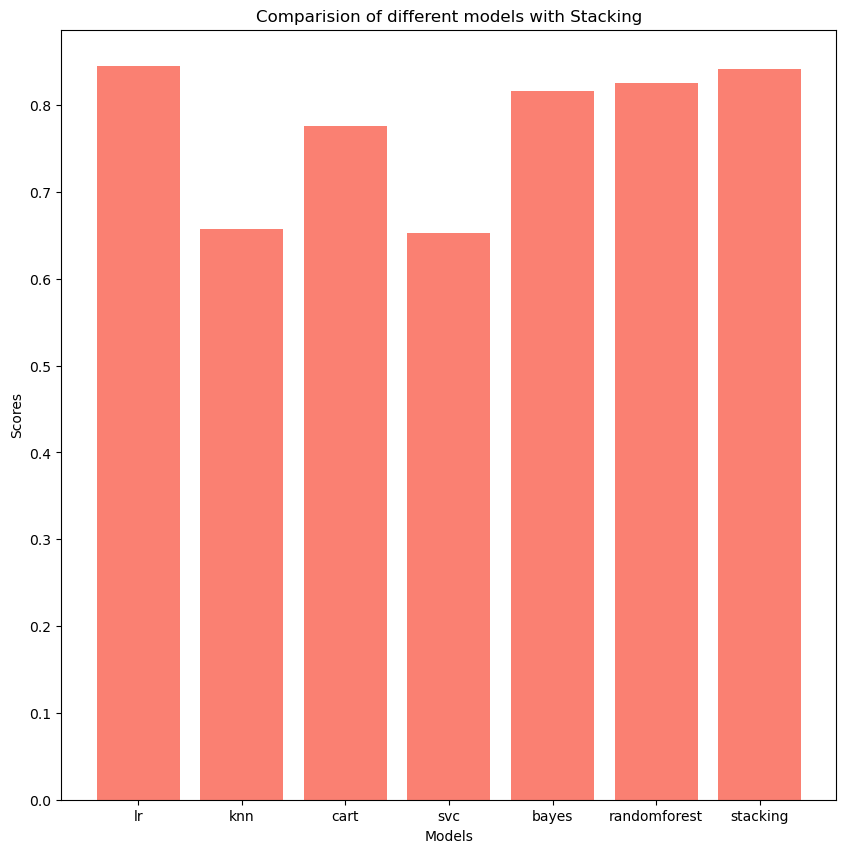

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
bar = ax.bar(list(results_clf.keys()),list(results_clf.values()),color='salmon')
ax.set(title="Comparision of different models with Stacking",xlabel="Models",ylabel="Scores");
plt.show();

# Regression - Stacking Ensemble Machine learning with python

In [31]:
#Importing Regression dataset
from sklearn.datasets import fetch_california_housing
Housing = fetch_california_housing()
California_df = pd.DataFrame(Housing.data,columns = Housing.feature_names)
California_df["target"]=Housing.target
California_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [32]:
California_df.shape

(20640, 9)

In [34]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

In [43]:
#Using 5 models for prediction and finding perfect fit
reg_models = {"lr":LinearRegression(), 
          "knn":KNeighborsRegressor(), 
          "cart":DecisionTreeRegressor(), 
          "svr":SVR(), 
          "randomforest":RandomForestRegressor()}

In [44]:
#Define Evaluation function - Generally for stacking cv is used
def evaluate_reg_model(model,X,y): 
    cv = KFold(n_splits=10,shuffle=True,random_state=42)
    scores = cross_val_score(model,X,y,scoring='neg_mean_absolute_error',cv=cv,n_jobs=-1,error_score='raise')
    return scores

In [45]:
X,y = California_df.drop("target",axis=1),California_df.target
results_reg={}

In [46]:
for name,model in reg_models.items(): 
    scores = evaluate_reg_model(model,X,y)
    results_reg[name]=np.mean(scores)
results_reg #The higher is better 

{'lr': -0.5320305343123044,
 'knn': -0.8073556819767443,
 'cart': -0.4571343197674419,
 'svr': -0.8685442801911254,
 'randomforest': -0.3217250686240312}

In [47]:
def get_stacking_reg():
    # Define base model
    level0 = list()
    level0.append(('lr',LinearRegression()))
    level0.append(('knn',KNeighborsRegressor()))
    level0.append(('cart',DecisionTreeRegressor()))
    level0.append(('svm',SVR()))
    level0.append(("randomforest",RandomForestRegressor()))
    #Define meta model
    level1 = LinearRegression()
    #Define the stacking ensemble
    reg = StackingRegressor(estimators=level0,final_estimator=level1,cv=5)
    return reg

In [48]:
# including regression stack model 
reg_models = {"lr":LinearRegression(), 
          "knn":KNeighborsRegressor(), 
          "cart":DecisionTreeRegressor(), 
          "svr":SVR(), 
          "randomforest":RandomForestRegressor(), 
          "stacking":get_stacking_reg()}

In [49]:
results_reg={}
for name, model in reg_models.items(): 
    scores = evaluate_reg_model(model,X,y)
    results_reg[name]=np.mean(scores)
    print(f"Processing {name}....")
results_reg # Take some time to process

Processing lr....
Processing knn....
Processing cart....
Processing svr....
Processing randomforest....
Processing stacking....


{'lr': -0.5320305343123044,
 'knn': -0.8073556819767443,
 'cart': -0.45961320542635653,
 'svr': -0.8685442801911254,
 'randomforest': -0.3235268033430234,
 'stacking': -0.3495465249219721}

#### Here also stacking has one of the best performance over other model 

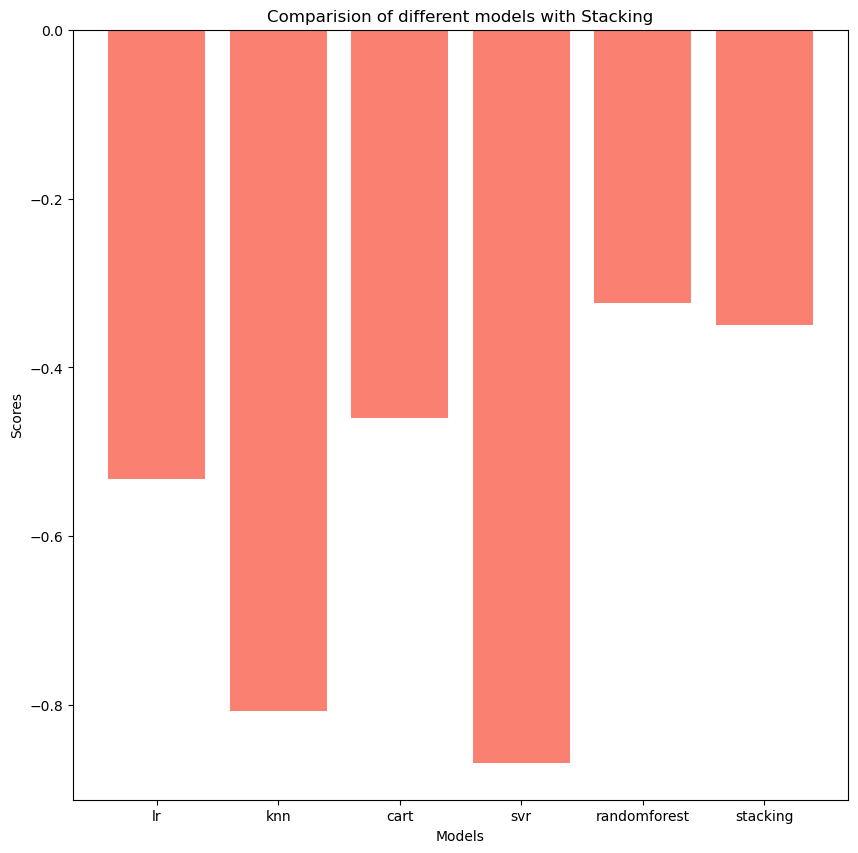

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
bar = ax.bar(list(results_reg.keys()),list(results_reg.values()),color='salmon')
ax.set(title="Comparision of different models with Stacking",xlabel="Models",ylabel="Scores");
plt.show();